In [1]:
#import Revise
import Statistics: mean, cor
import AbstractTrees: PreOrderDFS
import Makie
import CairoMakie
import Ab4Paper2023
using Statistics
using AbstractTrees
using Ab4Paper2023: minilib_2023, Data

In [ ]:
using StatsBase
using DataFrames: DataFrame
using DataFrames

In [ ]:
import PhageTree
import Ab4App
using PhageTree: Data, energies
using Ab4App: build_model, posonly, moving_average, onehot2aa, onehot2codon, codon2aa, nt2aa, experiment_with_targets
using Ab4App.Small_Experiment_2023: minilib_2023, probed_2023_proteins
using Ab4App.Small_Experiment_2023

In [2]:
# filter by constant region match?
constfilter = true
fullfilter = true # full const region filtering or just 5 sites on the right?
# :codons or :protein?
seqtype = :protein
stop_codons = false # include stop codons (e.g. TAG)?
minilib = "MINILIB_3"

"MINILIB_3"

In [3]:
## Analysis of validation experiment datasets
### Experiments with blue, black and bead targets 
### Experimental enrichments and model energies comparison 

### Import validation datasets

In [4]:
testset_root = minilib_2023(; as=seqtype, minilib=minilib)#, constfilter, fullfilter);
testset_data_raw = Data(testset_root);

In [5]:
Ab4Paper2023.probed_minilib_2023_dir(minilib=minilib)

"/Users/cossio/Developer/Projects/2021/ab4/src/../data/validation_set/minilib3_github"

In [6]:
seqs_testset,headers,_,seqs_dict_probed, df = Ab4Paper2023.probed_2023_proteins();

In [ ]:
## PROBED SEQUQUENCES
#### model designed

In [7]:
#### specificity
#black
idx_PT_black_spe=vcat(df[(df.origin.=="PT") .& (df.target.=="black") .& (df.opt.=="spe"),:].indexes...)
#blue
idx_PT_blue_spe=vcat(df[(df.origin.=="PT") .& (df.target.=="blue") .& (df.opt.=="spe"),:].indexes...)
#cross
idx_PT_cross_spe=vcat(df[(df.origin.=="PT") .& (df.target.=="cross") .& (df.opt.=="spe"),:].indexes...);
#### all
idx_PT_spe=vcat(df[(df.origin.=="PT") .& (df.opt.=="spe"),:].indexes...);

LoadError: ArgumentError: column name :indexes not found in the data frame

In [ ]:
#### affinity
#black
idx_PT_black=vcat(df[(df.origin.=="PT") .& (df.target.=="black"),:].indexes...)
#blue
idx_PT_blue=vcat(df[(df.origin.=="PT") .& (df.target.=="blue"),:].indexes...)
#cross
idx_PT_cross=vcat(df[(df.origin.=="PT") .& (df.target.=="cross"),:].indexes...);

In [8]:
### Positive control 
#black
idx_poscntrl_black=vcat(df[
        ((df.origin.=="STV") .| (df.origin.=="CNT") ) .&
        (df.target.=="black")
        ,:].indexes...)
#blue
idx_poscntrl_blue=vcat(df[
        ((df.origin.=="STV") .| (df.origin.=="CNT") ) .&
        (df.target.=="blue"),:].indexes...)
#cross
idx_poscntrl_cross=vcat(df[(df.origin.=="CNT") .& (df.target.=="cross"),:].indexes...)

### negative control
idx_cntrl_=vcat(df[(df.origin.=="STV") .& (df.target.=="no"),:].indexes...)

idx_negcntrl=idx_cntrl_[2:3]
idx_negcntrl_false=idx_cntrl_[1];

LoadError: ArgumentError: column name :indexes not found in the data frame

### Compute enrichment ratios in the experiments

In [ ]:
testset_freqs = testset_data.counts ./ sum(testset_data.counts; dims=1);

In [ ]:
testset_bioseqs = onehot2aa(testset_data.sequences)
testset_seqs_idx = Dict(seq => s for (s, seq) in enumerate(testset_bioseqs))
testset_freqs = testset_data.counts ./ sum(testset_data.counts; dims=1);
testset_exps_idx = Dict(
	n.label => i for (i,n) in enumerate(PreOrderDFS(testset_root))
)

testset_is = Dict(
	(target,t,σ)  => testset_exps_idx[σ*"_"*"$t"*"_$target"] for t in 1:2 for σ in ["o+","o-"] for target in ["black", "blue"]
) #round

testset_as = Dict(k => testset_data.ancestors[i] for (k,i) in testset_is) #ancestor

#testset_ = (data=testset_data,freqs=testset_freqs,seqs=testset_bioseqs,idx=testset_seqs_idx,as=testset_as,is=testset_is);

In [ ]:
#testset_freqs[findall(testset_freqs.==0)].=1
testset_sel = cat([(
			testset_freqs[:, testset_is[target,t,σ]] ./ 
			testset_freqs[:, testset_as[target,t,σ]]
		) for target in ["black", "blue"] for t in 1:2  for σ in ["o+","o-"]]...,dims=2);

In [ ]:
testset_sel = log.(testset_sel);

In [ ]:
testset_idx = Dict{Tuple,Int}()
k=1
for target in ["black", "blue"] 
    for t in 1:2  
        for σ in ["o+","o-"]
            testset_idx[(target,t,σ)] = k
            k+=1
        end
    end
end

### validation dataset: black-blue enrichments

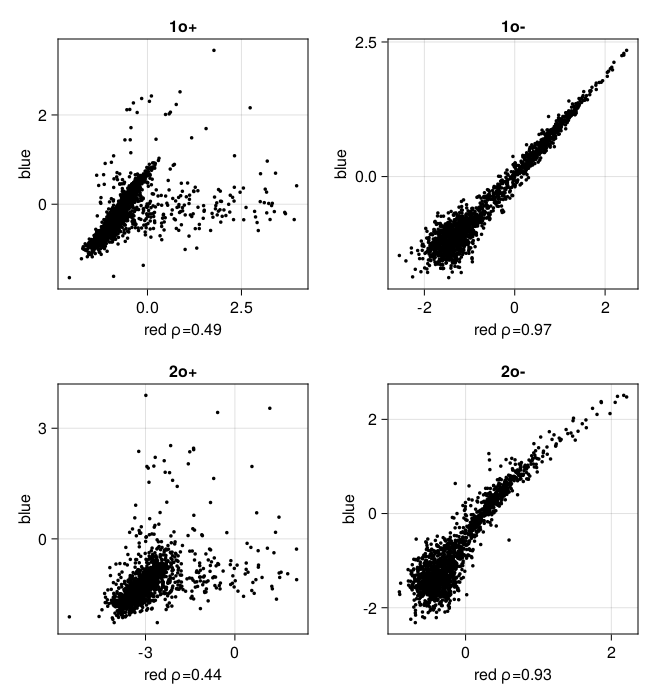

In [ ]:
begin
	fig = Makie.Figure()
	
    ################################
    
    for t in 1:2, (c,σ) in enumerate(["o+", "o-"])
        
        idx=findall(
            (.!isinf.(testset_sel[:,testset_idx[("black",t,σ)]])) .& (.!isnan.(testset_sel[:,testset_idx[("black",t,σ)]])) .&
            (.!isinf.(testset_sel[:,testset_idx[("blue",t,σ)]])) .& (.!isnan.(testset_sel[:,testset_idx[("blue",t,σ)]]))
        )

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		ρ = round(cor(x,y), digits=2)

		tit="hairpins ligand"
		xlab="Black enrichment"
		ylab="Blue enrichment"
		if	σ=="o-" 
			tit="Beads control enrichments"
			xlab="Beads Black enrichment"
			ylab="Beads Blue enrichment"
		end

		ax = Makie.Axis(
			fig[t, c], title=tit, ## title target -> control beads
			width=250, height=250,
			xticks=Makie.LogTicks(Makie.WilkinsonTicks(2)),
			yticks=Makie.LogTicks(Makie.WilkinsonTicks(2)),
			xlabel=xlab,
            ylabel=ylab
		)
		Makie.scatter!(ax, x, y, markersize = 5, color = :black)
    end
    
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	fig
end
    

In [ ]:
### import training dataset


In [ ]:
trainingset_root = experiment_with_targets(
	; which=:trainingset, as=seqtype, constfilter, fullfilter
);
trainingset_data = Data(trainingset_root);

In [ ]:
### import pre-trained model


In [ ]:
JLD2.@load "generative_model.jld2"

In [ ]:
#### Model Modes

In [ ]:
dd=Dict()
E_ind=Dict{String,Int}()
[dd[ws[k][1]]=k  for k in keys(ws)]
for k=1:length(keys(dd))
    println(k," ",dd[k])
    E_ind[string(dd[k])]=k
end

1 black
2 blue
3 amplification
4 deplification
5 wash
6 beads


In [ ]:
### compute energies

In [ ]:
E = energies(trainingset_data.sequences,model);
E_testset = energies(testset_data.sequences,model);

In [ ]:
E_column=E_ind;

In [ ]:
#### Generative procedure: threshold on energies
thr_E= [0.3 0.3;0.7 1.3]

In [28]:
function filter_inf_nan(idx,t,σ) 
    idx_=(
        (.!isinf.(testset_sel[idx,testset_idx[("black",t,σ)]])) .& 
        (.!isnan.(testset_sel[idx,testset_idx[("black",t,σ)]])) .&
        (.!isinf.(testset_sel[idx,testset_idx[("blue",t,σ)]])) .& 
        (.!isnan.(testset_sel[idx,testset_idx[("blue",t,σ)]]))
    )
    return idx[ idx_ ]
end

filter_inf_nan (generic function with 1 method)

## Affinity tested candidates
### SI figures () 

In [ ]:
function roc(label_v,idx_sort;normalized::Bool=false)
    np=sum(label_v.==1);
    nn=sum(label_v.==0);
    if normalized
        tpr=[sum(label_v[idx_sort[1:i]])/np for i in 1:length(label_v)];
        fpr=[-sum(label_v[idx_sort[1:i]].-1)/nn for i in 1:length(label_v)];
    else
        tpr=[sum(label_v[idx_sort[1:i]]) for i in 1:length(label_v)];
        fpr=[-sum(label_v[idx_sort[1:i]].-1) for i in 1:length(label_v)];
    end
    return tpr,fpr
end

function AUC(label,idx_s)
    np = sum(label.==1);
    l = length(label);
    tpr = [sum(label[idx_s[1:i]])/np for i in 1:length(label)];
    return sum(tpr)/l
end

AUC (generic function with 1 method)

In [ ]:
#### threshold on enerichments for ROC curve

In [ ]:
threshold_fun(x)=mean(x[isfinite.(x)])+2*std(x[isfinite.(x)])

threshold_fun (generic function with 1 method)

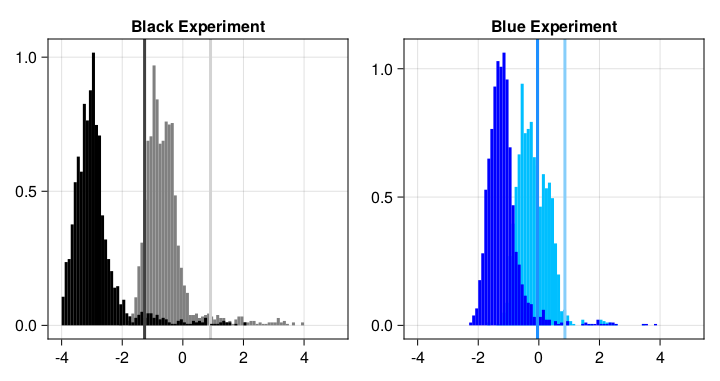

In [41]:
begin
	fig = Makie.Figure()
	
    bins=collect(-4:0.1:5)
    thr_sel=Dict{Tuple,Float64}()
    σ="o+"
    
    ax=[]
	push!(ax, Makie.Axis(
			fig[1,1], title="Black Experiment",
			width=300, height=300,
      ylabel="Enrichment"
		))
    push!(ax,Makie.Axis(
			fig[1,2], title="Blue Experiment",
			width=300, height=300,
      ylabel="Enrichment"
		))  
        
    ################################
    target="black"
    r=1
    
    sel = testset_sel[:,testset_idx[(target,r,σ)]]
    Makie.hist!(ax[1],sel,bins=bins, normalization = :pdf,color = :gray)
    thr_=threshold_fun(sel)
    Makie.vlines!(ax[1],thr_,color=:lightgray,linewidth=3)
    thr_sel[(target,r,σ)]=thr_

    ##################
    r=2

    sel = testset_sel[:,testset_idx[(target,r,σ)]]
    Makie.hist!(ax[1],sel,bins=bins, normalization = :pdf,color = :black)
    thr_=threshold_fun(sel)
    Makie.vlines!(ax[1],thr_,color=:gray25,linewidth=3)
    thr_sel[(target,r,σ)]=thr_
    
    ################################
    target="blue"
    r=1
    
    sel = testset_sel[:,testset_idx[(target,r,σ)]]
    Makie.hist!(ax[2],sel,bins=bins, normalization = :pdf,color = :trainingsetskyblue)
    thr_=threshold_fun(sel)
    Makie.vlines!(ax[2],thr_,color=:lightskyblue,linewidth=3)
    thr_sel[(target,r,σ)]=thr_


    ##################
    r=2

    sel = testset_sel[:,testset_idx[(target,r,σ)]]
    Makie.hist!(ax[2],sel,bins=bins, normalization = :pdf,color = :blue)
    thr_=threshold_fun(sel)
    Makie.vlines!(ax[2],thr_,color=:dodgerblue,linewidth=3)
    thr_sel[(target,r,σ)]=thr_


  legend(["round 1","round 2"])
    
  Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	fig
end

black 1 0.92
black 2 0.91
blue 1 0.79
blue 2 0.83


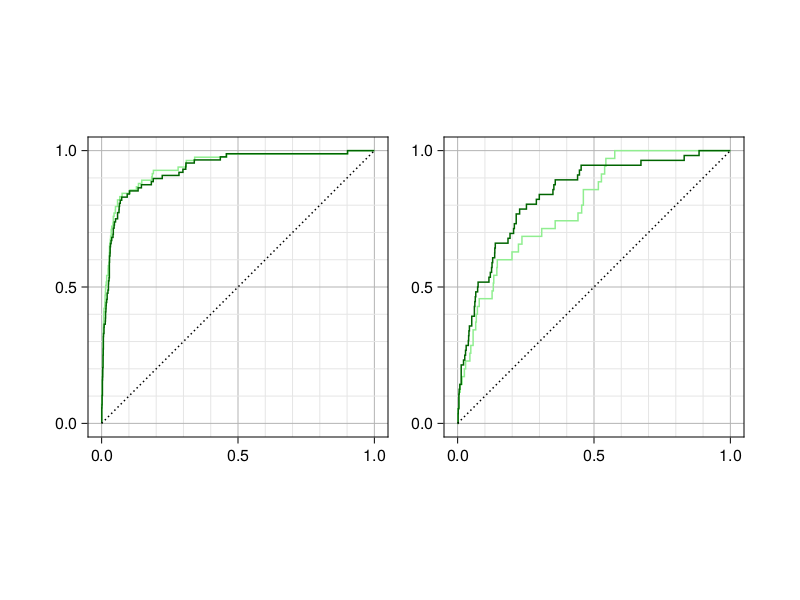

In [112]:
begin
fig = Makie.Figure()


#####################
ax=[]
push!(ax, Makie.Axis(
			fig[1,1],# title="Black Experiment",
			width=300, height=300,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 1,
    ygridwidth = 1,
    xminorgridcolor = :gray90,
    yminorgridcolor = :gray90,
    xminorgridvisible = true,
    yminorgridvisible = true,
    xminorticks = Makie.IntervalsBetween(5),
    yminorticks = Makie.IntervalsBetween(5)
    )
)

push!(ax, Makie.Axis(
			fig[1,2],# title="Blue Experiment",
			width=300, height=300,
            xgridcolor = :gray70,
            ygridcolor = :gray70,
            xgridwidth = 1,
            ygridwidth = 1,
            xminorgridcolor = :gray90,
            yminorgridcolor = :gray90,
            xminorgridvisible = true,
            yminorgridvisible = true,
            xminorticks = Makie.IntervalsBetween(5),
            yminorticks = Makie.IntervalsBetween(5)
        )
)

#####################

target="black"
r=1
σ="o+"
    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[1],fpr,tpr,label= "1o+ ρ=$auc",color=:lightgreen)
println("black $r ",auc)

r=2
    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[1],fpr,tpr,label= "1o+ ρ=$auc",color=:darkgreen)
Makie.lines!(ax[1],[0,maximum(fpr)],[0,maximum(tpr)],linestyle=:dot,color=:black)#,"--",color="black")
println("black $r ",auc)


#####################

target="blue"
r=1
σ="o+"
    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[2],fpr,tpr,label= "1o+ ρ=$auc",color=:lightgreen)

    
println("blue $r ",auc)

r=2
    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[2],fpr,tpr,label= "1o+ ρ=$auc",color=:darkgreen)
Makie.lines!(ax[2],[0,maximum(fpr)],[0,maximum(tpr)],linestyle=:dot,color=:black)#,"--",color="black")

println("blue $r ",auc)

fig
    end 

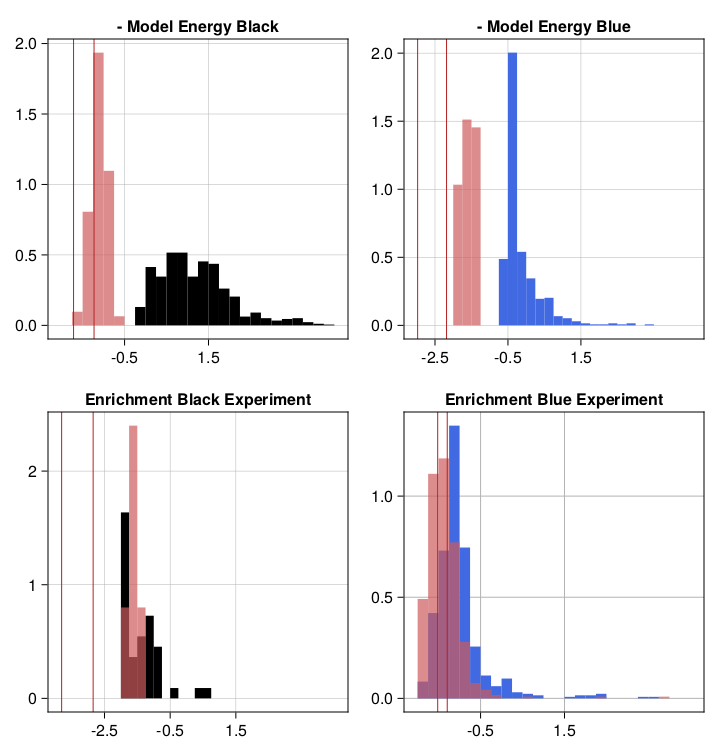

In [46]:
begin
    
fig = Makie.Figure()


#####################
ax=[]

push!(ax, Makie.Axis(
			fig[1,1], title="- Model Energy Black",
			width=300, height=300,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 0.5,
    ygridwidth = 0.5,
    xticks = -2.5:2:2.5
    )
)

push!(ax, Makie.Axis(
			fig[1,2], title="- Model Energy Blue",
			width=300, height=300,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 0.5,
    ygridwidth = 0.5,
    xticks = -2.5:2:2.5
    )
    
)

push!(ax, Makie.Axis(
			fig[2,1], title="Enrichment Black Experiment",
			width=300, height=300,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 0.5,
    ygridwidth = 0.5,
    xticks = -2.5:2:2.5
    )
)

push!(ax, Makie.Axis(
			fig[2,2], title="Enrichment Blue Experiment",
			width=300, height=300,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 1,
    ygridwidth = 1,
    xticks = -2.5:2:2.5
    )
)

#####################


en=E_testset

bins=collect(-2:0.25:4.5)

            ## ENERGY
            ##############"black"

            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="black"),:].indexes...)
            Makie.hist!(ax[1],-en[idx_,E_ind["black"]],bins=bins, normalization=:pdf,color=:black)
    
            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="blue") .& (df.opt.=="spe") ,:].indexes...)
            Makie.hist!(ax[1],-en[idx_,E_ind["black"]],bins=bins, normalization=:pdf,color=(:indianred,0.7))

            Makie.vlines!(ax[1],-en[idx_negcntrl,E_ind["black"]],color=:firebrick,linewidth=1)

           ##############"blue"

            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="blue"),:].indexes...)
            Makie.hist!(ax[2],-en[idx_,E_ind["blue"]],bins=bins, normalization=:pdf,color=:royalblue)
    
            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="black") .& (df.opt.=="spe") ,:].indexes...)
            Makie.hist!(ax[2],-en[idx_,E_ind["blue"]],bins=bins, normalization=:pdf,color=(:indianred,0.7))

            Makie.vlines!(ax[2],-en[idx_negcntrl,E_ind["blue"]],color=:firebrick,linewidth=1)


            ## SELECTIVITY
            ##############"black"

            r=2

            sel = testset_sel[:,testset_idx[("black",r,"o+")]]


            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="black"),:].indexes...)
            Makie.hist!(ax[3],sel[filter_inf_nan(idx_,r,σ)],bins=bins, normalization=:pdf,color=:black)
    
            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="blue") .& (df.opt.=="spe") ,:].indexes...)
            Makie.hist!(ax[3],sel[filter_inf_nan(idx_,r,σ)],bins=bins, normalization=:pdf,color=(:indianred,0.7))

            Makie.vlines!(ax[3],sel[idx_negcntrl],color=:firebrick,linewidth=1)

           ##############"blue"

            sel = testset_sel[:,testset_idx[("blue",r,"o+")]]

            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="blue"),:].indexes...)
            Makie.hist!(ax[4],sel[filter_inf_nan(idx_,r,σ)],bins=bins, normalization=:pdf,color=:royalblue,alpha=1.)
    
            idx_ = vcat(df[(df.origin.=="PT") .& (df.target.=="black") .& (df.opt.=="spe") ,:].indexes...)
            Makie.hist!(ax[4],sel[filter_inf_nan(idx_,r,σ)],bins=bins, normalization=:pdf,color=(:indianred,0.7))

            Makie.vlines!(ax[4],sel[idx_negcntrl],color=:firebrick,linewidth=1)

   	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	fig
end

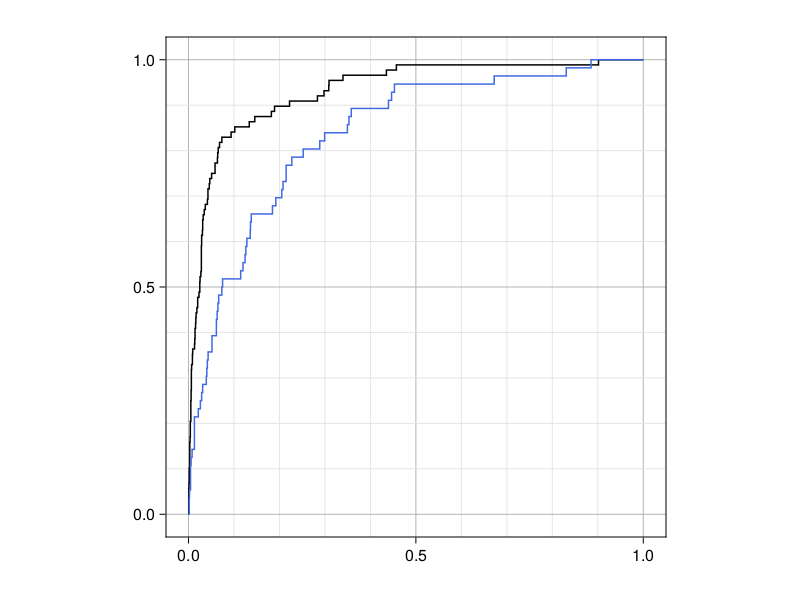

In [47]:
begin
fig = Makie.Figure()

r=2
σ="o+"

#####################
ax=[]
push!(ax, Makie.Axis(
			fig[1,1],# title="Black Experiment",
			width=500, height=500,
    xgridcolor = :gray70,
    ygridcolor = :gray70,
    xgridwidth = 1,
    ygridwidth = 1,
    xminorgridcolor = :gray90,
    yminorgridcolor = :gray90,
    xminorgridvisible = true,
    yminorgridvisible = true,
    xminorticks = Makie.IntervalsBetween(5),
    yminorticks = Makie.IntervalsBetween(5)
    )
)
#####################

target="black"
    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[1],fpr,tpr,label= "1o+ ρ=$auc",color=:black)

#####################

target="blue"

    
# sorting on E
idx_sortE=sortperm(E_testset[:,E_ind[target]]);

# label based on threshold on selectivity
sel = testset_sel[:,testset_idx[(target,r,σ)]]
thr=thr_sel[(target,r,σ)];
label=(sel.>thr);
tpr,fpr=roc(label,idx_sortE,normalized=true)
auc= round(AUC(label,idx_sortE),digits=2)
Makie.lines!(ax[1],fpr,tpr,label= "1o+ ρ=$auc",color=:royalblue)
fig
    end 

## Specifcity profiles validation

In [48]:
# using KernelDensity
# function plot_dens(x,y) 
#     dens_c=kde((x,y));
#     ik = InterpKDE(dens_c)
#     vect_color = [pdf(ik, x[k], y[k]) for k=1:length(x)]
#     return vect_color
# end

plot_dens (generic function with 1 method)

In [ ]:
#### CANDIDATES SELECTION 
## black-blue model energies thresholds


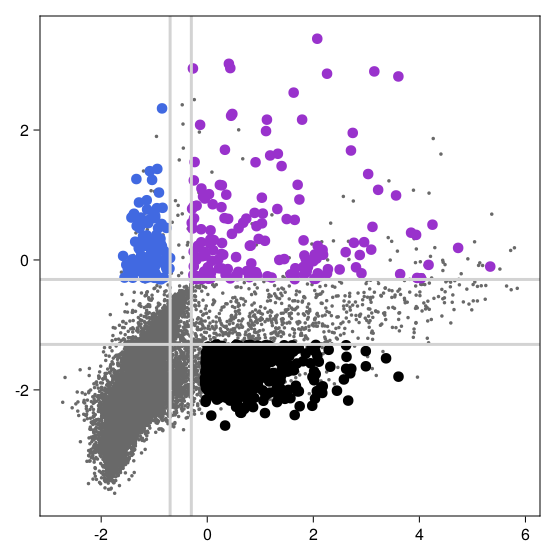

In [108]:
begin
	fig = Makie.Figure()
	    
	ax= Makie.Axis(
			fig[1,1], #title="",
			width=500, height=500,
            xgridvisible = false,
            ygridvisible = false,
		)
    markersize = 15
    

state1 = 1
state2 = 2
   
Makie.scatter!(ax,-E[:,state1],-E[:,state2],color=:dimgray,  markersize = 5)#Makie.colormap(:heat,logscale=true))    

#black specific PhageTree
idx=vcat(df[(df.origin.=="PT") .& (df.opt.=="spe") .& (df.target.=="black"),:indexes]...)
Makie.scatter!(ax,-E_testset[idx,state1],-E_testset[idx,state2], color=:black, markersize = markersize, marker=:circle)

# #blue specific PhageTree
idx=vcat(df[(df.origin.=="PT") .& (df.opt.=="spe") .& (df.target.=="blue"),:indexes]...)
Makie.scatter!(ax,-E_testset[idx,state1],-E_testset[idx,state2], color=:royalblue, markersize = markersize, marker=:circle)

# #cross specific PhageTree
idx=vcat(df[(df.origin.=="PT") .& (df.opt.=="spe") .& (df.target.=="cross"),:indexes]...)
Makie.scatter!(ax,-E_testset[idx,state1],-E_testset[idx,state2], color=:darkorchid, markersize = markersize, marker=:circle)


 Makie.vlines!(-thr_E[1,1],minimum(-E[:,2]),maximum(-E[:,2]),color=:lightgray,linewidth=3)
 Makie.vlines!(-thr_E[2,1],minimum(-E[:,2]),maximum(-E[:,2]),color=:lightgray,linewidth=3)
 Makie.hlines!(-thr_E[1,2],minimum(-E[:,1]),maximum(-E[:,1]),color=:lightgray,linewidth=3)
 Makie.hlines!(-thr_E[2,2],minimum(-E[:,1]),maximum(-E[:,1]),color=:lightgray,linewidth=3)
    
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
    Makie.save("Figure3-panelA.png", fig, px_per_unit = 4) 
	fig
end

### Candidates validation

In [51]:
threshold_fun2(x)=mean(x[isfinite.(x)]);

In [52]:
### round 1
σ="o+"
thr_=[ threshold_fun2(  testset_sel[:,testset_idx[("black",1,σ)]] ) threshold_fun2(  testset_sel[:,testset_idx[("blue",1,σ)]] );
    threshold_fun2(  testset_sel[:,testset_idx[("black",2,σ)]] ) threshold_fun2(  testset_sel[:,testset_idx[("blue",2,σ)]] )]

n_true_spec=zeros(2,3);

In [109]:
#### functions indexes in regions
function find_idx_in_black(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx = findall(((x.> thr_[t,1]) .& (y.<thr_[t,2]) ))
    return idx[_idx]
end

function find_idx_in_blue(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx = findall(((x.< thr_[t,1]) .& (y.>thr_[t,2]) ))
    return idx[_idx]
end

function find_idx_in_cross(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx = findall(((x.> thr_[t,1]) .& (y.>thr_[t,2]) ))
    return idx[_idx]
end

find_idx_in_cross (generic function with 1 method)

In [118]:
println(
length(find_idx_in_black(idx_PT_spe))/length(idx_PT_spe)," ",
length(find_idx_in_blue(idx_PT_spe))/length(idx_PT_spe)," ",
length(find_idx_in_cross(idx_PT_spe))/length(idx_PT_spe)," ");


0.07077326343381389 0.10615989515072084 0.1782437745740498 


### true positive rate round 1

In [54]:
## black true specific 
idx_ = idx_PT_black_spe
n_true_spec[1,1]=length(find_idx_in_black(idx_))/length(idx_)
length(find_idx_in_black(idx_))/length(idx_) , length(find_idx_in_black(idx_PT_spe))/length(idx_PT_spe), length(find_idx_in_black(idx_))/length(find_idx_in_black(idx_PT_spe))

(0.08125, 0.07077326343381389, 0.7222222222222222)

In [55]:
## blue true specific 
idx_ = idx_PT_blue_spe
n_true_spec[1,2]=length(find_idx_in_blue(idx_))/length(idx_) 
length(find_idx_in_blue(idx_))/length(idx_) , length(find_idx_in_blue(idx_PT_spe))/length(idx_PT_spe), length(find_idx_in_blue(idx_))/length(find_idx_in_blue(idx_PT_spe))

(0.1935483870967742, 0.10615989515072084, 0.2962962962962963)

In [56]:
## cross true specific 
idx_ = idx_PT_cross_spe
n_true_spec[1,3]=length(find_idx_in_cross(idx_))/length(idx_)
length(find_idx_in_cross(idx_))/length(idx_) , length(find_idx_in_cross(idx_PT_spe))/length(idx_PT_spe), length(find_idx_in_cross(idx_))/length(find_idx_in_cross(idx_PT_spe))

(0.44654088050314467, 0.1782437745740498, 0.5220588235294118)

#### composition in the quadrants

In [110]:
## percentage in black quadrant
freq_black_region=(
        length(find_idx_in_black(idx_PT_black_spe))/length(find_idx_in_black(idx_PT_spe)),
        length(find_idx_in_black(idx_PT_blue_spe))/length(find_idx_in_black(idx_PT_spe)),
        length(find_idx_in_black(idx_PT_cross_spe))/length(find_idx_in_black(idx_PT_spe))
)
println("composition in black quadrant")
println(freq_black_region)

    
## percentage in blue quadrant
freq_blue_region=(
        length(find_idx_in_blue(idx_PT_black_spe))/length(find_idx_in_blue(idx_PT_spe)),
        length(find_idx_in_blue(idx_PT_blue_spe))/length(find_idx_in_blue(idx_PT_spe)),
        length(find_idx_in_blue(idx_PT_cross_spe))/length(find_idx_in_blue(idx_PT_spe))
)
println("composition in blue quadrant")
println(freq_blue_region)
    
    
## percentage in cross quadrant
freq_cross_region=(
        length(find_idx_in_cross(idx_PT_black_spe))/length(find_idx_in_cross(idx_PT_spe)),
        length(find_idx_in_cross(idx_PT_blue_spe))/length(find_idx_in_cross(idx_PT_spe)),
        length(find_idx_in_cross(idx_PT_cross_spe))/length(find_idx_in_cross(idx_PT_spe))
)
println("composition in cross quadrant")
println(freq_cross_region)
    

composition in black quadrant
(0.7222222222222222, 0.018518518518518517, 0.25925925925925924)
composition in blue quadrant
(0.43209876543209874, 0.2962962962962963, 0.2716049382716049)
composition in cross quadrant
(0.3014705882352941, 0.17647058823529413, 0.5220588235294118)


### round 2

In [59]:
## black true specific 
idx_ = idx_PT_black_spe
length(find_idx_in_black(idx_;t=2))/length(idx_) , length(find_idx_in_black(idx_PT_spe;t=2))/length(idx_PT_spe), length(find_idx_in_black(idx_;t=2))/length(find_idx_in_black(idx_PT_spe;t=2))

(0.11458333333333333, 0.10353866317169069, 0.6962025316455697)

In [60]:
## blue true specific 
idx_ = idx_PT_blue_spe
length(find_idx_in_blue(idx_;t=2))/length(idx_) , length(find_idx_in_blue(idx_PT_spe;t=2))/length(idx_PT_spe), length(find_idx_in_blue(idx_;t=2))/length(find_idx_in_blue(idx_PT_spe;t=2))

(0.23387096774193547, 0.14809960681520315, 0.25663716814159293)

In [61]:
## cross true specific 
idx_ = idx_PT_cross_spe
length(find_idx_in_cross(idx_;t=2))/length(idx_) , length(find_idx_in_cross(idx_PT_spe;t=2))/length(idx_PT_spe), length(find_idx_in_cross(idx_;t=2))/length(find_idx_in_cross(idx_PT_spe;t=2))

(0.42138364779874216, 0.19921363040629095, 0.4407894736842105)

#### composition in the quadrants

In [62]:
## percentage in black quadrant
freq_black_region=(
        length(find_idx_in_black(idx_PT_black_spe;t=2))/length(find_idx_in_black(idx_PT_spe;t=2)),
        length(find_idx_in_black(idx_PT_blue_spe;t=2))/length(find_idx_in_black(idx_PT_spe;t=2)),
        length(find_idx_in_black(idx_PT_cross_spe;t=2))/length(find_idx_in_black(idx_PT_spe;t=2))
)
println("composition in black quadrant")
println(freq_black_region)
    
## percentage in blue quadrant
freq_blue_region=(
        length(find_idx_in_blue(idx_PT_black_spe;t=2))/length(find_idx_in_blue(idx_PT_spe;t=2)),
        length(find_idx_in_blue(idx_PT_blue_spe;t=2))/length(find_idx_in_blue(idx_PT_spe;t=2)),
        length(find_idx_in_blue(idx_PT_cross_spe;t=2))/length(find_idx_in_blue(idx_PT_spe;t=2))
)
println("composition in blue quadrant")
println(freq_blue_region)
    
    
## percentage in cross quadrant
freq_cross_region=(
        length(find_idx_in_cross(idx_PT_black_spe;t=2))/length(find_idx_in_cross(idx_PT_spe;t=2)),
        length(find_idx_in_cross(idx_PT_blue_spe;t=2))/length(find_idx_in_cross(idx_PT_spe;t=2)),
        length(find_idx_in_cross(idx_PT_cross_spe;t=2))/length(find_idx_in_cross(idx_PT_spe;t=2))
)
println("composition in cross quadrant")
println(freq_cross_region)
    

composition in black quadrant
(0.6962025316455697, 0.06329113924050633, 0.24050632911392406)
composition in blue quadrant
(0.5132743362831859, 0.25663716814159293, 0.23008849557522124)
composition in cross quadrant
(0.34868421052631576, 0.21052631578947367, 0.4407894736842105)


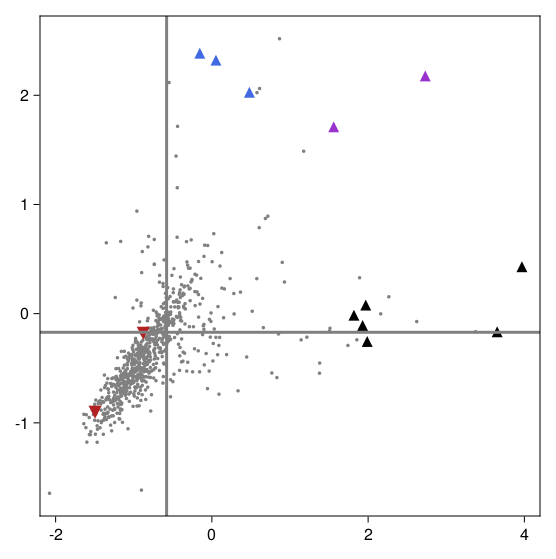

In [ ]:
begin
	fig = Makie.Figure()
	
    σ="o+"
    t=1
    ############################
    
    
    ax=[]
	push!(ax, Makie.Axis(
			fig[1,1], #title="1$σ",
			width=500, height=500,
            xgridvisible = false,
            ygridvisible = false,
            xticks = [-2,0,2,4],
            limits = ((-2.2, 4.2), nothing),
            yticks=[-1,0,1,2]
			xlabel="black enrichment",
            ylabel="blue enrichment"
		))

    
    
    #     ########################################
#     # all seqs
#     ################################
    idx_=vcat(df[(df.origin.=="PT") .& (df.opt.=="spe"),:].indexes...)

    color = :gray 
    marker = :circle
    markersize = 5


    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color)
    
  
    ########################################
    ### control seqs
    ################################
    idx_ = idx_poscntrl_black
    color = :black
    marker = :utriangle
    markersize = 15
    
    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax[t], x, y, markersize = markersize, marker=marker, color = color)#,alpha=0.5)

    ###############################    
    idx_ = idx_poscntrl_blue
    color = :royalblue
    marker = :utriangle
    markersize = 15
    
    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax[t], x, y, markersize = markersize, marker=marker, color = color)#,alpha=0.5)
    
    
    
    ###############################    
    idx_ = idx_poscntrl_cross
    color = :darkorchid
    marker = :utriangle
    markersize = 15
    
    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax[t], x, y, markersize = markersize,marker=marker, color = color)#,alpha=0.5)
    
    ###############################    
    idx_ = idx_negcntrl
    color = :firebrick
    marker = :dtriangle
    markersize = 18
    
    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax[t], x, y, markersize = markersize,marker=marker, color = color)
    
    ###############################

    Makie.vlines!(ax[1],[thr_[1,1]],color=:gray,linewidth=3)
    Makie.hlines!(ax[1],[thr_[1,2]],color=:gray,linewidth=3)

    
    #############################
    
    
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
        Makie.save("Fig:SI_thr.png", fig, px_per_unit = 4) 
    
    legend(["Red specific","Blue specific","Cross specific","Red positive control", "Blue positive control", "Cross positive control", "Negative control"],
    loc="center left", bbox_to_anchor=(1, 0.5))
    
    fig
end
    

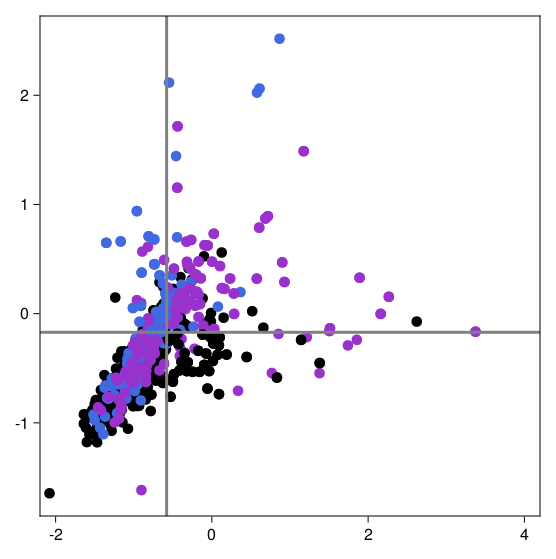

In [114]:
begin
	fig = Makie.Figure()
	
    σ="o+"
    t=1
    markersize = 15
    marker = :circle    

    
    ax=[]
	push!(ax, Makie.Axis(
			fig[1,1], #title="1$σ",
			width=500, height=500,
            xgridvisible = false,
            ygridvisible = false,
            xticks = [-2,0,2,4],
            limits = ((-2.2, 4.2), nothing),
            yticks=[-1,0,1,2],
            xlabel="black enrichment",
            ylabel="blue enrichment"
		))

    
    ########################################
    # generated seqs all
    
    alpha=1.
    
    ################################
    idx_ = idx_PT_black_spe
    color = :black 

        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
        
        ###false positive
		Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color,alpha=alpha)
     
#     ###############################    
    idx_ = idx_PT_blue_spe
    color = :royalblue

    
    
      idx=filter_inf_nan(idx_,t,σ) 
		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
        
        ###false positive
		Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color,alpha=alpha)

    
#     ###############################    
    idx_ = idx_PT_cross_spe
    color = :darkorchid
    
        idx=filter_inf_nan(idx_,t,σ) 

		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
        
        ###false positive
		Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color,alpha=alpha)

#############################################
    # generated seqs true positive
    
    
    #     ###############################    
    color = :darkorchid
    
    idx_ = idx_PT_cross_spe
    idx=filter_inf_nan(idx_,t,σ) 
    idx_ = find_idx_in_cross(idx;t=t,σ=σ)
        
    x = testset_sel[idx_,testset_idx[("black",t,σ)]]
    y = testset_sel[idx_,testset_idx[("blue",t,σ)]] 
	Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color)
    ###################
    
        color = :black 

        idx_ = idx_PT_black_spe
        idx=filter_inf_nan(idx_,t,σ) 
        idx_ = find_idx_in_black(idx;t=t,σ=σ)
    
        x = testset_sel[idx_,testset_idx[("black",t,σ)]]
        y = testset_sel[idx_,testset_idx[("blue",t,σ)]] 
		Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color)
    

#     ###############################    
    color = :royalblue
    
    idx_ = idx_PT_blue_spe
    idx=filter_inf_nan(idx_,t,σ) 
    idx_ = find_idx_in_blue(idx;t=t,σ=σ)
        
    x = testset_sel[idx_,testset_idx[("black",t,σ)]]
    y = testset_sel[idx_,testset_idx[("blue",t,σ)]] 
	Makie.scatter!(ax[t], x, y,  markersize = markersize, color = color)
    

    
    
#     ########################################


    Makie.vlines!(ax[1],[thr_[1,1]],color=:gray,linewidth=3)
    Makie.hlines!(ax[1],[thr_[1,2]],color=:gray,linewidth=3)

    
    
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
    Makie.save("Figure3-panelB.png", fig, px_per_unit = 4) 

	fig
    
end
    

## Thresholds on ratios of black-blue enrichments

In [350]:
function center_mass(x; thr_iqr=1.5)
    iqrx=iqr(x)
    nqx=nquantile(x,4)
    lower_bound = nqx[2] - thr_iqr * iqrx
    upper_bound = nqx[4] + thr_iqr * iqrx
    center_of_mass = mean(x[ (x.>lower_bound) .& (x.<upper_bound)])
end

center_mass (generic function with 1 method)

In [352]:
#round
t=1
σ="o+"
x = testset_sel[:, testset_idx[("black",t,σ)]]
y = testset_sel[:, testset_idx[("blue",t,σ)]]
ref_x = center_mass(x)
ref_y = center_mass(y)
ref_x,ref_y

(-0.7249686208898144, -0.19551448954412937)

In [354]:
### blue limit
x = testset_sel[idx_poscntrl_blue ,testset_idx[("black",t,σ)]]
y = testset_sel[idx_poscntrl_blue, testset_idx[("blue",t,σ)]]

ratio_bl=minimum((y.-ref_y)./(x.-ref_x))

1.8306482336504506

In [355]:
### black limit
idx = idx_poscntrl_black
x = testset_sel[idx_poscntrl_black, testset_idx[("black",t,σ)]]
y = testset_sel[idx_poscntrl_black, testset_idx[("blue",t,σ)]]
ratio_bk=maximum((y.-ref_y)./(x.-ref_x))

0.12967806763737882

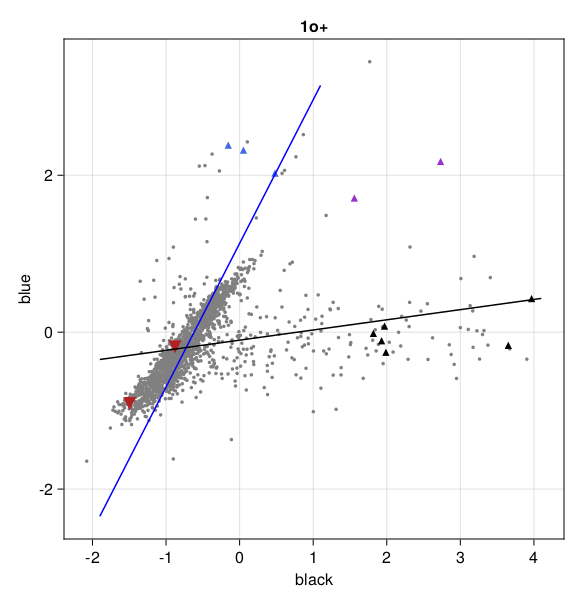

In [356]:
begin
	fig = Makie.Figure()
	
    t=1
    σ="o+"
    markersize = 15

    ############################
    
    
    ax=Makie.Axis(
			fig[1,1], title="1$σ",
			width=500, height=500,
			xlabel="black",
            ylabel="blue"
		)
    
    
        #####################################
    x = testset_sel[:,testset_idx[("black",t,σ)]]
y = testset_sel[:,testset_idx[("blue",t,σ)]]
Makie.scatter!(ax, x, y, markersize = 7,marker=:circle, color = "gray")
    
    

###############################    
    
    idx_ = idx_poscntrl_black
    color = :black
    marker = :utriangle
    idx=filter_inf_nan(idx_,t,σ) 
		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax, x, y, markersize = markersize, marker=marker, color = color)#,alpha=0.5)    
    
    idx = idx_poscntrl_blue
    color = :royalblue
    marker = :utriangle
        #idx=filter_inf_nan(idx_,t,σ) 
		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax, x, y, markersize = markersize, marker=marker, color = color)#,alpha=0.5)

    
    idx_ = idx_poscntrl_cross
    color = :darkorchid
    marker = :utriangle
        idx=filter_inf_nan(idx_,t,σ) 
		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax, x, y, markersize = markersize,marker=marker, color = color)#,alpha=0.5)
    
    idx_ = idx_negcntrl
    color = :firebrick
    marker = :dtriangle
        idx=filter_inf_nan(idx_,t,σ) 
		x = testset_sel[idx,testset_idx[("black",t,σ)]]
        y = testset_sel[idx,testset_idx[("blue",t,σ)]]
		Makie.scatter!(ax, x, y, markersize = markersize,marker=marker, color = color)
    

    ###################################
    #DRAW LINES

    ############################### 
    #blue line
    x=[-1.9,1.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bl,ref_y+(x[2]-ref_x)*ratio_bl]
    Makie.lines!(ax,x,y,color="blue")
    ############################
    #black line
    x=[-1.9,4.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bk,ref_y+(x[2]-ref_x)*ratio_bk]
    Makie.lines!(ax,x,y,color="black")
    #############################
    
    
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	
    legend(["Red specific","Blue specific","Cross specific","Red positive control", "Blue positive control", "Cross positive control", "Negative control"],
    loc="center left", bbox_to_anchor=(1, 0.5))
    
    fig
end 

In [357]:
function find_idx_in_black(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx=findall(((y.-ref_y).<ratio_bk.*(x.-ref_x)) .& ((y.-ref_y).<ratio_bl.*(x.-ref_x)))
    return idx[_idx]
end

function find_idx_in_blue(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx=findall(((y.-ref_y).>ratio_bk.*(x.-ref_x)) .& ((y.-ref_y).>ratio_bl.*(x.-ref_x)))
    return idx[_idx]
end

function find_idx_in_cross(idx::Vector{Int};t=1,σ="o+")
    
    x = testset_sel[idx,testset_idx[("black",t,σ)]]
    y = testset_sel[idx,testset_idx[("blue",t,σ)]]
    _idx=findall(((y.-ref_y).>ratio_bk.*(x.-ref_x)) .& ((y.-ref_y).<ratio_bl.*(x.-ref_x)))
    return idx[_idx]
end

find_idx_in_cross (generic function with 1 method)

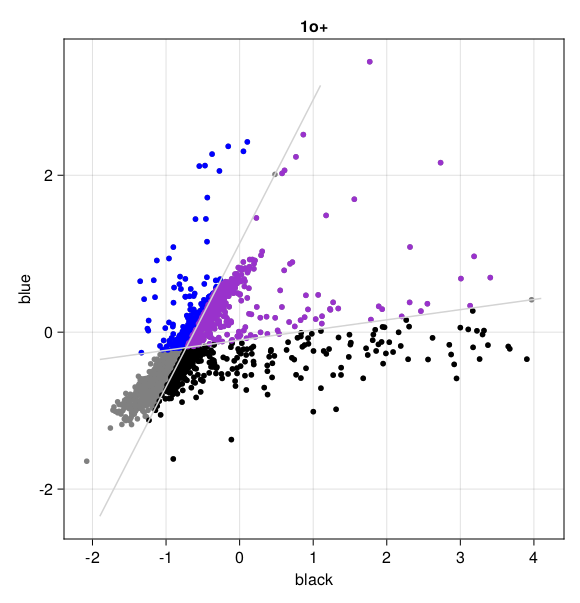

In [358]:
begin
	fig = Makie.Figure()
	
    σ="o+"
    
    ############################
     
    ax=[]
	push!(ax, Makie.Axis(
			fig[1,1], title="1$σ",
			width=500, height=500,
			xlabel="black",
            ylabel="blue"
		))
marker=:circle
######################

x = testset_sel[:,testset_idx[("black",t,σ)]]
y = testset_sel[:,testset_idx[("blue",t,σ)]]
Makie.scatter!(ax[1], x, y, markersize = 8,marker=marker, color = "gray")

idx=find_idx_tp_blue(collect(1:1816))
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "blue")
    
idx=find_idx_tp_black(collect(1:1816))
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "black")

idx=find_idx_tp_cross(collect(1:1816))
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "darkorchid")
   
    ############################### 
    #blue line
    x=[-1.9,1.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bl,ref_y+(x[2]-ref_x)*ratio_bl]
    Makie.lines!(ax[1],x,y,color="lightgray")
    ############################
    #black line
    x=[-1.9,4.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bk,ref_y+(x[2]-ref_x)*ratio_bk]
    Makie.lines!(ax[1],x,y,color="lightgray")
    #############################
        
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	fig
end

### true positive rate

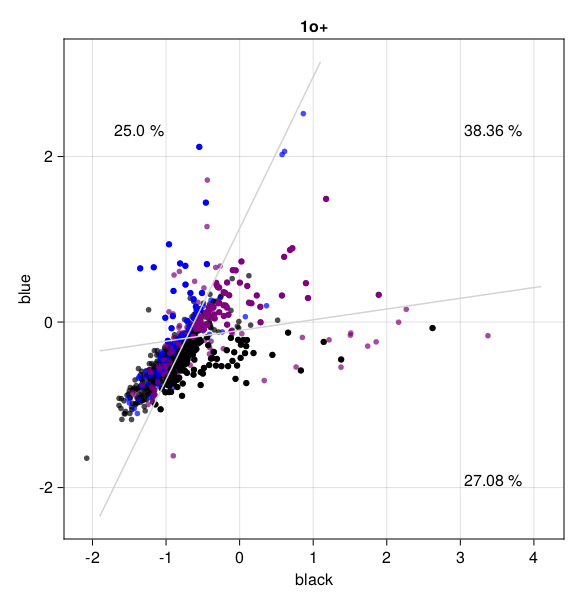

In [359]:
begin
	fig = Makie.Figure()
	
    σ="o+"
    
    ############################
    
    
    ax=[]
	push!(ax, Makie.Axis(
			fig[1,1], title="1$σ",
			width=500, height=500,
			xlabel="black",
            ylabel="blue"
		))
marker=:circle
######################

x = testset_sel[:,testset_idx[("black",t,σ)]]
y = testset_sel[:,testset_idx[("blue",t,σ)]]
    
    
idx=idx_PT_black_spe
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "black",alpha=0.7)
    
idx=idx_PT_blue_spe
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "blue",alpha=0.7)

idx=idx_PT_cross_spe
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 8,marker=marker, color = "purple",alpha=0.7)

idx=find_idx_in_black(idx_PT_black_spe)
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 9,marker=marker, color = "black")
    
idx=find_idx_in_blue(idx_PT_blue_spe)
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 9,marker=marker, color = "blue")

idx=find_idx_in_cross(idx_PT_cross_spe)
Makie.scatter!(ax[1], x[idx], y[idx], markersize = 9,marker=marker, color = "purple")
   
    ############################### 
    #blue line
    x=[-1.9,1.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bl,ref_y+(x[2]-ref_x)*ratio_bl]
    Makie.lines!(ax[1],x,y,color="lightgray")
    ############################
    #black line
    x=[-1.9,4.1]
    y=[ref_y+(x[1]-ref_x)*ratio_bk,ref_y+(x[2]-ref_x)*ratio_bk]
    Makie.lines!(ax[1],x,y,color="lightgray")
    #############################
        
        n=round( length(find_idx_in_black(idx_PT_black_spe))./length(idx_PT_black_spe) *100,digits=2)
        Makie.text!(ax[1],"$n %", space = :relative, position = Makie.Point2f(0.8, 0.1))
        
        n=round( length(find_idx_in_blue(idx_PT_blue_spe))./length(idx_PT_blue_spe) *100,digits=2)
        Makie.text!(ax[1],"$n %",space = :relative, position = Makie.Point2f(0.1, 0.8))

        n=round( length(find_idx_in_cross(idx_PT_cross_spe))./length(idx_PT_cross_spe) *100,digits=2)
        Makie.text!(ax[1],"$n %",space = :relative, position = Makie.Point2f(0.8, 0.8))
        
	Makie.update_state_before_display!(fig)
	Makie.resize_to_layout!(fig)
	fig
end

#### TP RATE

In [360]:
idx_bk_region=find_idx_in_black(idx_PT_spec)
idx_bl_region=find_idx_in_blue(idx_PT_spec)
idx_cr_region=find_idx_in_cross(idx_PT_spec);

In [361]:
length(find_idx_in_black(idx_PT_black_spe))/length(idx_PT_black_spe) ,  length(idx_bk_region)/length(idx_PT_spec)

(0.2708333333333333, 0.2437745740498034)

In [362]:
length(find_idx_in_blue(idx_PT_blue_spe))./length(idx_PT_blue_spe) ,  length(idx_bl_region)/length(idx_PT_spec)

(0.25, 0.10091743119266056)

In [363]:
length(find_idx_in_cross(idx_PT_cross_spe))./length(idx_PT_cross_spe) ,  length(idx_cr_region)/length(idx_PT_spec)

(0.3836477987421384, 0.1913499344692005)

#### composition in the quadrants

In [364]:
## percentage in black quadrant
freq_black_region=(
        length(find_idx_in_black(idx_PT_black_spe;t=1))/length(find_idx_in_black(idx_PT_spe;t=1)),
        length(find_idx_in_black(idx_PT_blue_spe;t=1))/length(find_idx_in_black(idx_PT_spe;t=1)),
        length(find_idx_in_black(idx_PT_cross_spe;t=1))/length(find_idx_in_black(idx_PT_spe;t=1))
)
println("composition in black quadrant")
println(freq_black_region)
    
## percentage in blue quadrant
freq_blue_region=(
        length(find_idx_in_blue(idx_PT_black_spe;t=1))/length(find_idx_in_blue(idx_PT_spe;t=1)),
        length(find_idx_in_blue(idx_PT_blue_spe;t=1))/length(find_idx_in_blue(idx_PT_spe;t=1)),
        length(find_idx_in_blue(idx_PT_cross_spe;t=1))/length(find_idx_in_blue(idx_PT_spe;t=1))
)
println("composition in blue quadrant")
println(freq_blue_region)
    
    
## percentage in cross quadrant
freq_cross_region=(
        length(find_idx_in_cross(idx_PT_black_spe;t=1))/length(find_idx_in_cross(idx_PT_spe;t=1)),
        length(find_idx_in_cross(idx_PT_blue_spe;t=1))/length(find_idx_in_cross(idx_PT_spe;t=1)),
        length(find_idx_in_cross(idx_PT_cross_spe;t=1))/length(find_idx_in_cross(idx_PT_spe;t=1))
)
println("composition in cross quadrant")
println(freq_cross_region)
    

composition in black quadrant
(0.6989247311827957, 0.0967741935483871, 0.20430107526881722)
composition in blue quadrant
(0.23376623376623376, 0.4025974025974026, 0.36363636363636365)
composition in cross quadrant
(0.4315068493150685, 0.1506849315068493, 0.4178082191780822)
